<a href="https://colab.research.google.com/github/keyoumao/Defect_dP_PaCKage/blob/main/TEM_EDS_nanoparticles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDS-TEM quantification of core shell nanoparticles

Using machine learning methods, such as independent component analysis (ICA), the composition of embedded nanostructures, such as core-shell nanoparticles, can be accurately measured as demonstrated by D. Roussow et al., Nano Letters, 2015 (see the [full article](https://www.repository.cam.ac.uk/bitstream/handle/1810/248102/Roussouw%20et%20al%202015%20Nano%20Letters.pdf?sequence=1)). Using the same data, this notebook reproduces the main results of this article.


## Author

* 13/04/2015 Pierre Burdet - Developed for HyperSpy workshop at University of Cambridge

## Changes

* 29/05/2016 Duncan Johnstone. Update the syntax for HyperSpy 0.8.5 (Python 3 compatibility)
* 03/08/2016 Francisco de la Peña. Update the syntax for HyperSpy 1.1
* 06/08/2016 Francisco de la Peña. Update the syntax for HyperSpy 0.8.1
* 27/08/2016 Pierre Burdet. Update for workshop at EMC Lyon
* 04/04/2018 Joshua Taillon. Bugfix and update for workshop at NIST
* 18/07/2019 Katherine MacArthur. Update to include basic quantification, for M&M 2019 Portland

## Requirements

* HyperSpy 1.5.1

## <a id='top'></a> Contents

1. <a href='dat'> Specimen & Data</a>
2. <a href='#loa'> Loading and viewing data</a>
3. <a href='#counts'> Extracting Counts </a>
4. <a href='#quant'> Basic Quantification </a>
5. <a href='#bss'> Blind source separation of core/shell nanoparticles</a>
6. <a href='#bare'> Representative spectrum from bare cores</a>
7. <a href='#com'> Comparison and quantification</a>
8. <a href='#fur'> Going father: Isolating the nanoparticles</a>

# <a id='dat'></a> 1. Specimen & Data

The sample and the data used in this tutorial are described in 
D. Roussow, et al., Nano Letters, In Press (2015) (see the [full article](https://www.repository.cam.ac.uk/bitstream/handle/1810/248102/Roussouw%20et%20al%202015%20Nano%20Letters.pdf?sequence=1)).

FePt@Fe$_3$O$_4$ core-shell nanoparticles are investigated with an EDS/TEM experiment (FEI Osiris TEM, 4 EDS detectors). The composition of the core can be measured with ICA (see figure 1c). To prove the accuracy of the results, measurements on bare FePt bimetallic nanoparticles from a synthesis prior to the shell addition step are used.

<img src="images/core_shell.png" style="height:350px;">
Figure 1: (a) A spectrum image obtained from a cluster of core-shell nanoparticles. (b) The nanoparticles are comprised of a bi-metallic Pt/Fe core surrounded by an iron oxide shell on a carbon support. (c) ICA decomposes the mixed EDX signals into components representing the core (IC#0), shell (IC#1) and support (IC#2).

In [1]:
#Download the data (1MB)
from urllib.request import urlretrieve, urlopen
from zipfile import ZipFile
files = urlretrieve("https://www.dropbox.com/s/ecdlgwxjq04m5mx/HyperSpy_demos_EDS_TEM_files.zip?raw=1", "./HyperSpy_demos_EDX_TEM_files.zip")
with ZipFile("HyperSpy_demos_EDX_TEM_files.zip") as z:
    z.extractall()

# <a id='loa'></a> 2. Loading and viewing data

<a href='#top'> Table of contents</a>

Import HyperSpy, numpy and matplotlib libraries.

*Remember, if at any point you do not understand how a function operates, its help file can be loaded by typing the name of the command followed by a '?' into a cell and then running that cell.*

In [2]:
!pip install hyperspy
!matplotlib qt
import hyperspy.api as hs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.6/32.6 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.0/203.0 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.5/269.5 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 63.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=4c5b7aed5798d125cd0d84e0e142ee45c2e0bf696579a26c3d0ea439d23d365d
  Stored in directory: /root/.cache/pip/wheels/a3/d7/75/19cd0d2a

Load the spectrum images of the bare nanoparticles and those with a core-shell structure.

In [3]:
c = hs.load("bare_core.hdf5")
cs = hs.load("core_shell.hdf5")

/usr/local/lib/python3.8/dist-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


Check the metadata has imported correctly. In particular whether the list of elements you wish to analyse is correct.

In [4]:
cs.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 0.0
│       │       ├── elevation_angle = 35.0
│       │       └── energy_resolution_MnKa = 130.0
│       ├── Stage
│       │   └── tilt_alpha = 0.0
│       ├── acquisition_mode = STEM
│       ├── beam_energy = 200.0
│       └── microscope = Microscope TecnaiOsiris 200 kV D658 AnalyticalTwin
├── General
│   ├── FileIO
│   │   └── 0
│   │       ├── hyperspy_version = 1.7.3
│   │       ├── io_plugin = hyperspy.io_plugins.hspy
│   │       ├── operation = load
│   │       └── timestamp = 2023-02-13T22:20:02.209744+00:00
│   ├── date = 14.10.2014
│   └── title = Core shell
├── Sample
│   ├── elements = array(['Fe', 'Pt'], dtype='<U2')
│   └── xray_lines = array(['Fe_Ka', 'Pt_La'], dtype='<U5')
└── Signal
    ├── signal_origin = 
    └── signal_type = EDS_TEM

Plot the core-shell data to inspect the signal level:

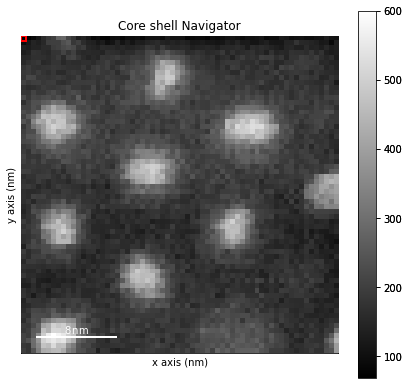

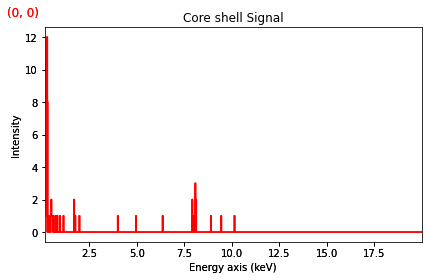

In [5]:
cs.plot()

Plotting the integrated counts for the whole spectrum image is a good way to check what elements exist in the sample. Adding 'True' to the function also labels any elements from the metadata onto the spectrum.

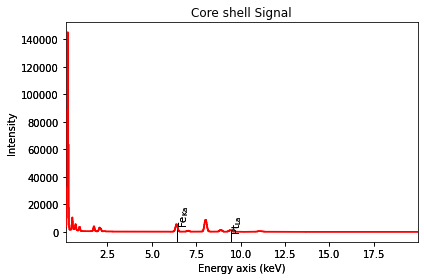

In [6]:
cs.sum().plot(True)

## <a id='#counts'></a> 3. Extracting count maps of elements

<a href='#top'> Table of contents</a>


If they're not already added it is important to make sure all the elements you want to extract the intensities for are in the metadata of the sample.

In [7]:
cs.set_elements(['Fe','Pt'])
cs.set_lines(['Fe_Ka', 'Pt_La'])

c.set_elements(['Fe','Pt'])
c.set_lines(['Fe_Ka', 'Pt_La'])
#cs.add_elements and cs.add_lines also work if you don't want to override what is 
#already in the metadata.

Extracting lines can be done without any background or integration window parameters. However if none are specified the default integration window is 1 FWHM and no background subtraction is carried out.

Line_width is the distance from the x-ray line (in FWHM) the the background window is taken [left, right] allowing different distances for the two directions.
An asymmetric value is used here because otherwise the Pt background windows overlap with the Cu K$_β$ line from the sample grid.

In [8]:
bw = cs.estimate_background_windows(line_width=[5.0, 2.0])
iw =  cs.estimate_integration_windows(windows_width=3)

It is important to plot the windows to check that they are selecting the data correctly otherwise errors, particularly in background subtraction arise.

The integration windows are represented by dashed lines and background windows by solid lines. The estimated background is the plotted by the close to horizontal black lines.

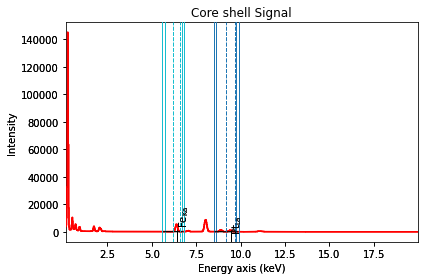

In [9]:
cs.sum().plot(True, background_windows=bw, integration_windows=iw)

*Try running the previous two cells of code  above with line_width=[3.0,3.0] and see how this results in an erroneous, background subtraction by plotting the background lines. (You might need to zoom in to see it)*

How accurate background subtraction will be on a pixel-by-pixel basis can be see with this plot. 

The x and y sliders select a pixel in the particle images we plotted earlier. 

You should be able to find some examples (e.g. the Fe K$_α$ line at X=39, Y=44) of where the background subtraction still fails due to a poor signal-to-noise ratio in the data.



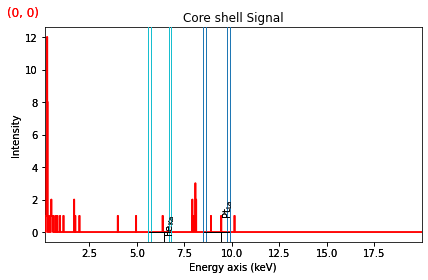

In [10]:
cs.plot(True, background_windows=bw, navigator='slider')

Another way to adjust the location of the background windows is by changing specific numbers in the background window array individually.

Running the 'bw' command will output the array, which contains keV coordinates corresponding to the position of the background windows. Each row corresponds to a different element in the list given in the metadata. Remember arrays in Python start at (0,0).

These two commands therefore alter the position of the start and end points of the left-hand background window for Pt.

In [11]:
bw[1, 0] = 8.44
bw[1, 1] = 8.65
bw

array([[5.59527895, 5.73004913, 6.67344035, 6.80821052],
       [8.44      , 8.65      , 9.7630891 , 9.92358364]])

Often it is prudent to rebin the data such that counts per pixel are increased and a more reliable background subtraction can be carried out. This can be easily done with the rebin function to any new scale.

These functions will perform rebinning on both the core-shell ('cs') data and the core-only ('c') data. We define using the 'scale' parameter that we want 2x binning in X, 2x binning in Y, and 1x binning in Z (our counts).

*Note, as we are re-defining 'cs' or 'c', this overwrites our previously-imported data. This means running this command multiple times will re-bin the data multiple times. If you accidentally run this command too many times, simply re-import the data by running the 'hs.load' commands at the top of this workbook'.*

In [12]:
cs = cs.rebin(scale=(2,2,1))
c = c.rebin(scale=(2,2,1))

Finally, once the background subtraction windows have been selected to be in careful positions it is possible to extract the intensities. 

Note that exactly the same windows have been used for analysis of both the 'core' and 'core-shell' data sets. This is critical here as we are comparing the two datasets.

In [13]:
cs_intensities = cs.get_lines_intensity(background_windows=bw, integration_windows=iw)
c_intensities = c.get_lines_intensity(background_windows=bw, integration_windows=iw)

Each 'get_lines_intensity' command will create a list of images, again in the same order of the list of elements in the list of metadata. If the element is not in the metadata its intensity map will not be extracted.

We can then run 'cs_intensities' to confirm the that we have extracted intensity maps for all our elements of interest.

In [14]:
cs_intensities

[<BaseSignal, title: X-ray line intensity of Core shell: Fe_Ka at 6.40 keV, dimensions: (32, 32|)>,
 <BaseSignal, title: X-ray line intensity of Core shell: Pt_La at 9.44 keV, dimensions: (32, 32|)>]

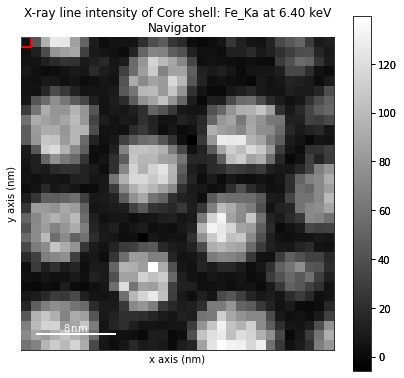

In [15]:
# Plotting one particular image (in this case, the first, Fe_Ka map) can be done with:
cs_intensities[0].plot()

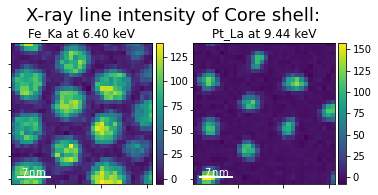

In [16]:
#All the intensity maps can be plotted using:
hs.plot.plot_images(cs_intensities, cmap='viridis', axes_decor=None, scalebar='all')

Plotting and extracting intensity for both data sets can be condensed into one line.

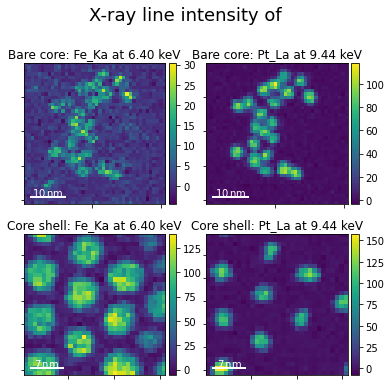

In [17]:
axes = hs.plot.plot_images((c.get_lines_intensity(background_windows=bw, integration_windows=iw)
                                          + cs.get_lines_intensity(background_windows=bw, integration_windows=iw)),
                           scalebar='all', axes_decor=None, per_row=2, cmap='viridis')

## <a id='#quant'></a> 4. Quantification of count maps

<a href='#top'> Table of contents</a>

Hyperspy is able to carry out EDX quantification using k-factors 'CL', zeta-factors 'zeta', or cross_sections 'cross_sections'. 

All these methods are applied in the same way using the combination of the stack of intensities and and original data.

For 'zeta' or 'cross_section' quantification both a 'live_time' and a 'beam_current' should be in the metadata.

In [18]:
#Setting these parameters in the metadata.
cs.set_microscope_parameters(live_time = 6.15) #in seconds
cs.set_microscope_parameters(beam_current = 0.5) #in nA

In [19]:
#From Brucker software (Esprit) k-factors
factors = [1.450226, 5.75602]

In [20]:
quant = cs.quantification(cs_intensities, 'CL', factors=factors)

[########################################] | 100% Completed |  0.1s


/usr/local/lib/python3.8/dist-packages/hyperspy/misc/material.py:61: RuntimeWarning: invalid value encountered in true_divide
  atomic_percent[i] /= sum_weight


In [21]:
quant

[<BaseSignal, title: atomic percent of Fe, dimensions: (32, 32|)>,
 <BaseSignal, title: atomic percent of Pt, dimensions: (32, 32|)>]

Again as with the intensities the quantification function result produces a list of images with atomic percent of each element (at least in the 'CL' case). 

In the 'zeta' and 'cross_section' methods more information is outputed from quantification. See the [EDS quantification](http://hyperspy.org/hyperspy-doc/current/user_guide/eds.html#eds-quantification) section of the documentation for more details.

Alternatively, if the factors are treated as cross_sections then the output result contains two lists of images, the first is a list of atomic *percent* maps (Index [0]) the second is a list of atomic *number* maps (Index [1]). This allows us to 'zero-out' regions of the image with too few counts.

*Please note these values aren't accurate cross-sections but can be used as such for the purpose of this demo.*

Ignore the warning produced, in this case we want to use a 1nm$^2$ probe size. As long as the pixel scale is calibrated in your spectrum image, probe size is taken as the pixel unless otherwise specified using s.set_microscope_parameters(probe_area = ?).

In [22]:
quant = cs.quantification(cs_intensities, 'cross_section', factors=factors)

/usr/local/lib/python3.8/dist-packages/hyperspy/_signals/eds_tem.py:833: UserWarning: Please note that the probe area has been calculated to be 1 nm², meaning that it is highly likley that the scale of the navigation axes have not been set correctly. Please read the user guide for how to set this.
  warnings.warn("Please note that the probe area has been "
/usr/local/lib/python3.8/dist-packages/hyperspy/misc/eds/utils.py:625: RuntimeWarning: invalid value encountered in true_divide
  composition = number_of_atoms / total_atoms


In [23]:
quant

([<BaseSignal, title: atomic percent of Fe, dimensions: (32, 32|)>,
  <BaseSignal, title: atomic percent of Pt, dimensions: (32, 32|)>],
 [<BaseSignal, title: atom counts of Fe, dimensions: (32, 32|)>,
  <BaseSignal, title: atom counts of Pt, dimensions: (32, 32|)>])

Summing all the images containing numbers of atoms (quant[1]) gives us an image mapping out the total number of estimated atoms in the sample.

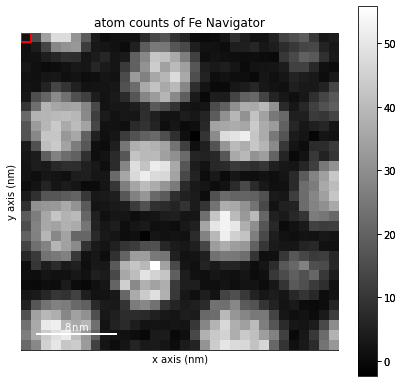

In [24]:
No_of_atoms = quant[1][0] + quant[1][1]
No_of_atoms.plot()

This 'total number of atoms' image can be used to make a mask and 'zero-out' any region of the image where the total counts equate to less than 1 atom count. This could also be done on an element by element basis instead.

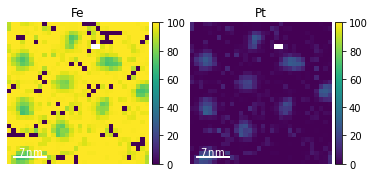

In [25]:
Mask = No_of_atoms > 1.
hs.plot.plot_images([Mask*quant[0][0], Mask*quant[0][1]], scalebar ='all', cmap='viridis',
                   label=['Fe', 'Pt'], axes_decor='off', vmin=0, vmax=100)

## <a id='bss'></a> 5. Blind source separation of core/shell nanoparticles

<a href='#top'> Table of contents</a>

Apply blind source separation (ICA) to obtain a factor (spectrum) corresponding to the core.

In [26]:
cs.change_dtype('float')
cs.decomposition()

Decomposition info:
  normalize_poissonian_noise=True
  algorithm=SVD
  output_dimension=None
  centre=None


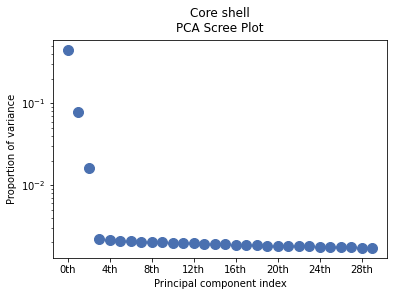

In [27]:
ax = cs.plot_explained_variance_ratio()

ICA on the three first components.

In [28]:
cs.blind_source_separation(3)

[########################################] | 100% Completed |  0.1s


Blind source separation info:
  number_of_components=3
  algorithm=sklearn_fastica
  diff_order=1
  reverse_component_criterion=factors
  whiten_method=PCA
scikit-learn estimator:
FastICA(tol=1e-10, whiten=False)


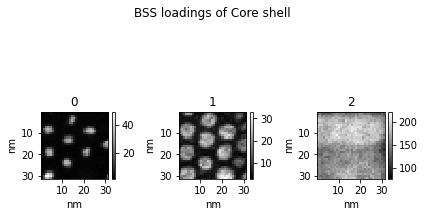

In [29]:
axes = cs.plot_bss_loadings()

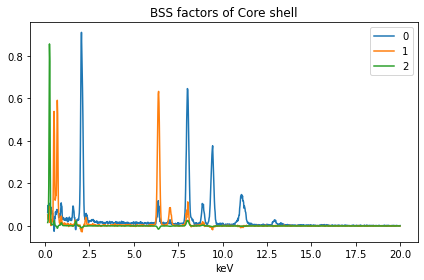

In [30]:
axes = cs.plot_bss_factors()

The first component corresponds to the core.

In [31]:
s_bss = cs.get_bss_factors().inav[0]

## <a id='bare'></a> 6. Representative spectrum from bare cores

<a href='#top'> Table of contents</a>

To obtain an integrated representative spectrum of the bare nanoparticles, the low intensity of Pt L$_{\alpha}$ is masked.

In [32]:
pt_la = c.get_lines_intensity(['Pt_La'])[0]
mask = pt_la > 12

TypeError: ignored

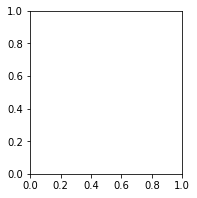

In [35]:
axes = hs.plot.plot_images((mask, pt_la * mask), axes_decor=None, colorbar=None,
                           label=['Mask', 'Pt Lα intensity'], cmap='viridis')

To apply the mask, the navigation dimensions of the mask must be manipulated to match the navigation dimensions of the EDS spectrum image. This is achieved crudely via first generating a mask using the built in vacuum_mask() method and then overwriting the data with the mask generated above.

In [ ]:
c_mask = c.sum(-1)
c_mask.data = mask.data

The sum over the particles is used as a bare core spectrum.

In [ ]:
s_bare = (c * c_mask).sum()

## <a id='com'></a> 7. Model fitting and quantification

<a href='#top'> Table of contents</a>

With a greater signal to noise ratio from integrating the spectrum curve fitting now beceoms possible as a method of intensity extraction. 

First we stack together the spectrum of bare particles and the first ICA component.

In [ ]:
s_bare.change_dtype('float')
s = hs.stack([s_bare, s_bss], new_axis_name='Bare or BSS')
s.metadata.General.title = 'Bare or BSS'

In [ ]:
axes = hs.plot.plot_spectra(s, style='mosaic', legend=['Bare particles', 'BSS #0'])

### Method 1 - Window extraction

X-ray intensities measurement with background subtraction, using the windows created earlier.

In [ ]:
s.plot(background_windows=bw, integration_windows=iw)

In [ ]:
sI = s.get_lines_intensity(background_windows=bw, integration_windows=iw)

In [ ]:
print('Bare core Fe_Kα/Pt_Lα ratio: \t{:.2f}'.format(list(sI[0].inav[0].data / sI[1].inav[0].data)[0]))
print('BSS Fe_Kα/Pt_Lα ratio: \t\t{:.2f}'.format(list(sI[0].inav[1].data / sI[1].inav[1].data)[0]))

### Method 2 - Model fitting

Measure X-ray intensity by fitting a Gaussian model

In [ ]:
#Removing the low energy part of the spectrum as this is not a region we're interested in.
m = s.isig[5.:15.].create_model()

In [ ]:
#These lines needed to be added to the model because they are not in the metadata. 
#In this way they are included in the curve fitting but not in the final quantification.
m.add_family_lines(['Cu_Ka', 'Co_Ka'])

In [ ]:
m.components

In [ ]:
m.plot()

In [ ]:
m.multifit()

In [ ]:
m.fit_background()

In [ ]:
m.calibrate_energy_axis()

In [ ]:
m.plot()

In [ ]:
sI = m.get_lines_intensity()[:2]
sI

Set up the kfactors for Fe K$_{\alpha}$ and Pt L$_{\alpha}$.

In [ ]:
#From Brucker software (Esprit)
kfactors = [1.450226, 5.075602]

Quantify with Cliff Lorimer.

In [ ]:
composition = s.quantification(method="CL", intensities=sI, factors=kfactors)

In [ ]:
print('             |-----------------------------|')
print('             |     Atomic compositions     |')
print('             |-----------------------------|')

print(' \t     |  Bare core  |   BSS Signal  |')
print('|------------|-------------|---------------|')
print('| Fe (at. %) |    {:.2f}    |     {:.2f}     |'.format(composition[0].data[0], composition[0].data[1]))
print('| Pt (at. %) |    {:.2f}    |     {:.2f}     |'.format(composition[1].data[0], composition[1].data[1]))
print('|------------|-------------|---------------|')

## <a id='fur'></a> 6. Going further

<a href='#top'> Table of contents</a>

Further image processing with [scikit-image](http://scikit-image.org/) and [scipy](http://www.scipy.org/). Apply a watershed transformation to isolate the nanoparticles.

- Transform the mask into a distance map.
- Find local maxima.
- Apply the watershed to the distance map using the local maximum as seed (markers).

Adapted from this scikit-image [example](http://scikit-image.org/docs/dev/auto_examples/plot_watershed.html).

In [ ]:
from scipy.ndimage import distance_transform_edt, label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

In [ ]:
distance = distance_transform_edt(mask.data)
local_maxi = peak_local_max(distance, indices=False,
                            min_distance=2, labels=mask.data)
labels = watershed(-distance, markers=label(local_maxi)[0],
                   mask=mask.data)

In [ ]:
axes = hs.plot.plot_images(
    [pt_la.T, mask.T, hs.signals.Signal2D(distance), hs.signals.Signal2D(labels)],
    axes_decor='off', per_row=2, colorbar=None, cmap=['viridis','tab20'],
    label=['Pt Lα intensity', 'Mask',
           'Distances', 'Separated particles'])